<a href="https://colab.research.google.com/github/roesta07/How-Business-Strategies-can-create-bias/blob/main/strategy_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports and utility functions
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install pymc3==3.9
    !pip install --upgrade daft
    !pip install --upgrade theano
    !pip install causalgraphicalmodels
    !pip install watermark
    !pip install arviz --no-dependencies
    !pip install netCDF4
    !pip install xarray

     |████████████████████████████████| 1.9MB 7.6MB/s 
     |████████████████████████████████| 1.6MB 24.2MB/s 
     |████████████████████████████████| 737kB 43.7MB/s 
     |████████████████████████████████| 4.7MB 44.6MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
     |████████████████████████████████| 317kB 56.3MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=30843a1da9f4957d4505eeb1afc553f4db3a98342443421d0978a57459e1cb25
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
  Created wheel for daft: filename=daft-0.1.0-cp36-none-any.whl size=11375 sha256=139848ffdc00bed5a76bbd8fcbf67cb552f3d7107e819a6710656c6

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
from scipy.optimize import curve_fit


from scipy.interpolate import griddata
from causalgraphicalmodels import CausalGraphicalModel

In [4]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
# %load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz€

In [80]:
## Data Generating Process
b_CO=1
b_UO=1
b_RP=2
b_UP=2
b_CP=0

n_samples=300
#regions
U = 2*np.random.binomial(1,0.3,size=n_samples)-1
C=np.random.normal(0,1,size=n_samples)
## which are regeions
R = np.random.normal(b_CO*C+b_UO*U,1,size=n_samples)
P=  np.random.normal(b_UP*U+b_RP*R+b_CP*C,2,size=n_samples)


In [81]:
## lets create a dataframe
df=pd.DataFrame(np.vstack([C,R,P,U]).T,columns=['C','R','P','U'])
df.head()

,C,R,P,U
0,-0.697934,-2.661714,-9.194782,-1.0
1,-0.092871,-1.647436,-4.562580,-1.0
2,-0.630655,-1.654477,-2.814229,-1.0
3,-0.795721,0.557335,-3.046409,-1.0
4,-0.910944,-0.765988,0.782381,1.0


In [82]:
## Some number transformations

def std_standarize(col):
  '''Takes in a numpy array, returns its standard unit'''
  return (col-col.mean())/col.std()

def normalize(col):
  '''Takes in a numpy array, returns min-max scale'''
  return col/col.max()

df=df.assign(C_std=std_standarize(df['C']),R_norm=normalize(df['R']),P_std=std_standarize(df['P']))
print(df['P_std'].mean())
df.head()


2.842170943040401e-16


,C,R,P,U,C_std,R_norm,P_std
0,-0.697934,-2.661714,-9.194782,-1.0,-0.699686,-0.680253,-1.515861
1,-0.092871,-1.647436,-4.562580,-1.0,-0.078422,-0.421034,-0.553129
2,-0.630655,-1.654477,-2.814229,-1.0,-0.630606,-0.422834,-0.189761
3,-0.795721,0.557335,-3.046409,-1.0,-0.800093,0.142438,-0.238016
4,-0.910944,-0.765988,0.782381,1.0,-0.918400,-0.195763,0.557739


In [151]:
## Modeling
with pm.Model() as m_2:
  a=pm.Normal('a',0,1)
  b_CP=pm.Normal('b_CP',0,1)
  b_RP=pm.Normal('b_RP',0,1)
  sigma=pm.Exponential('sigma',1)
  mu=pm.Deterministic('mu',a+b_CP*(df['C'])+b_RP*(df['R']))
  profit=pm.Normal('profit',mu=mu,sigma=sigma,observed=df['P'])
  trace_2=pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b_RP, b_CP, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.


In [86]:
az.summary(trace_2,round_to=2,var_names=['~mu'])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.67,0.14,-0.88,-0.45,0.0,0.0,1524.83,1468.49,1518.21,1279.27,1.0
b_CP,-0.92,0.18,-1.24,-0.67,0.0,0.0,1537.44,1532.57,1543.74,1411.53,1.0
b_RP,2.86,0.11,2.70,3.04,0.0,0.0,1350.81,1350.81,1356.71,1219.52,1.0
sigma,2.40,0.10,2.24,2.55,0.0,0.0,2233.69,2217.24,2334.05,1382.81,1.0


/usr/local/lib/python3.6/dist-packages/arviz/utils.py:661: UserWarning: Keyword argument credible_interval has been deprecated Please replace with hdi_prob
  ("Keyword argument credible_interval has been deprecated " "Please replace with hdi_prob"),
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


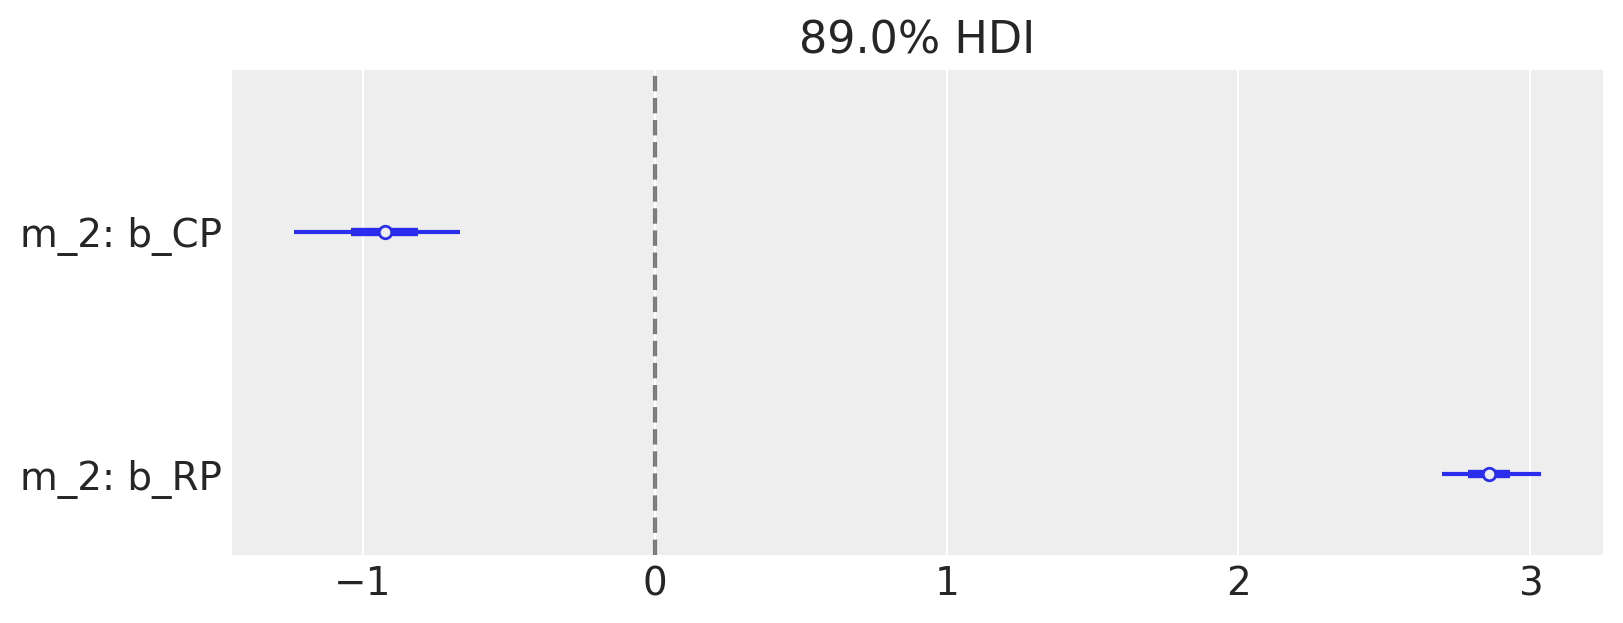

In [88]:
az.plot_forest([trace_2],model_names=['m_2'],var_names=['b_CP','b_RP'],credible_interval=0.89,combined=True,figsize=(8,3),)
plt.axvline(0,ls='--',color='k',alpha=0.5)


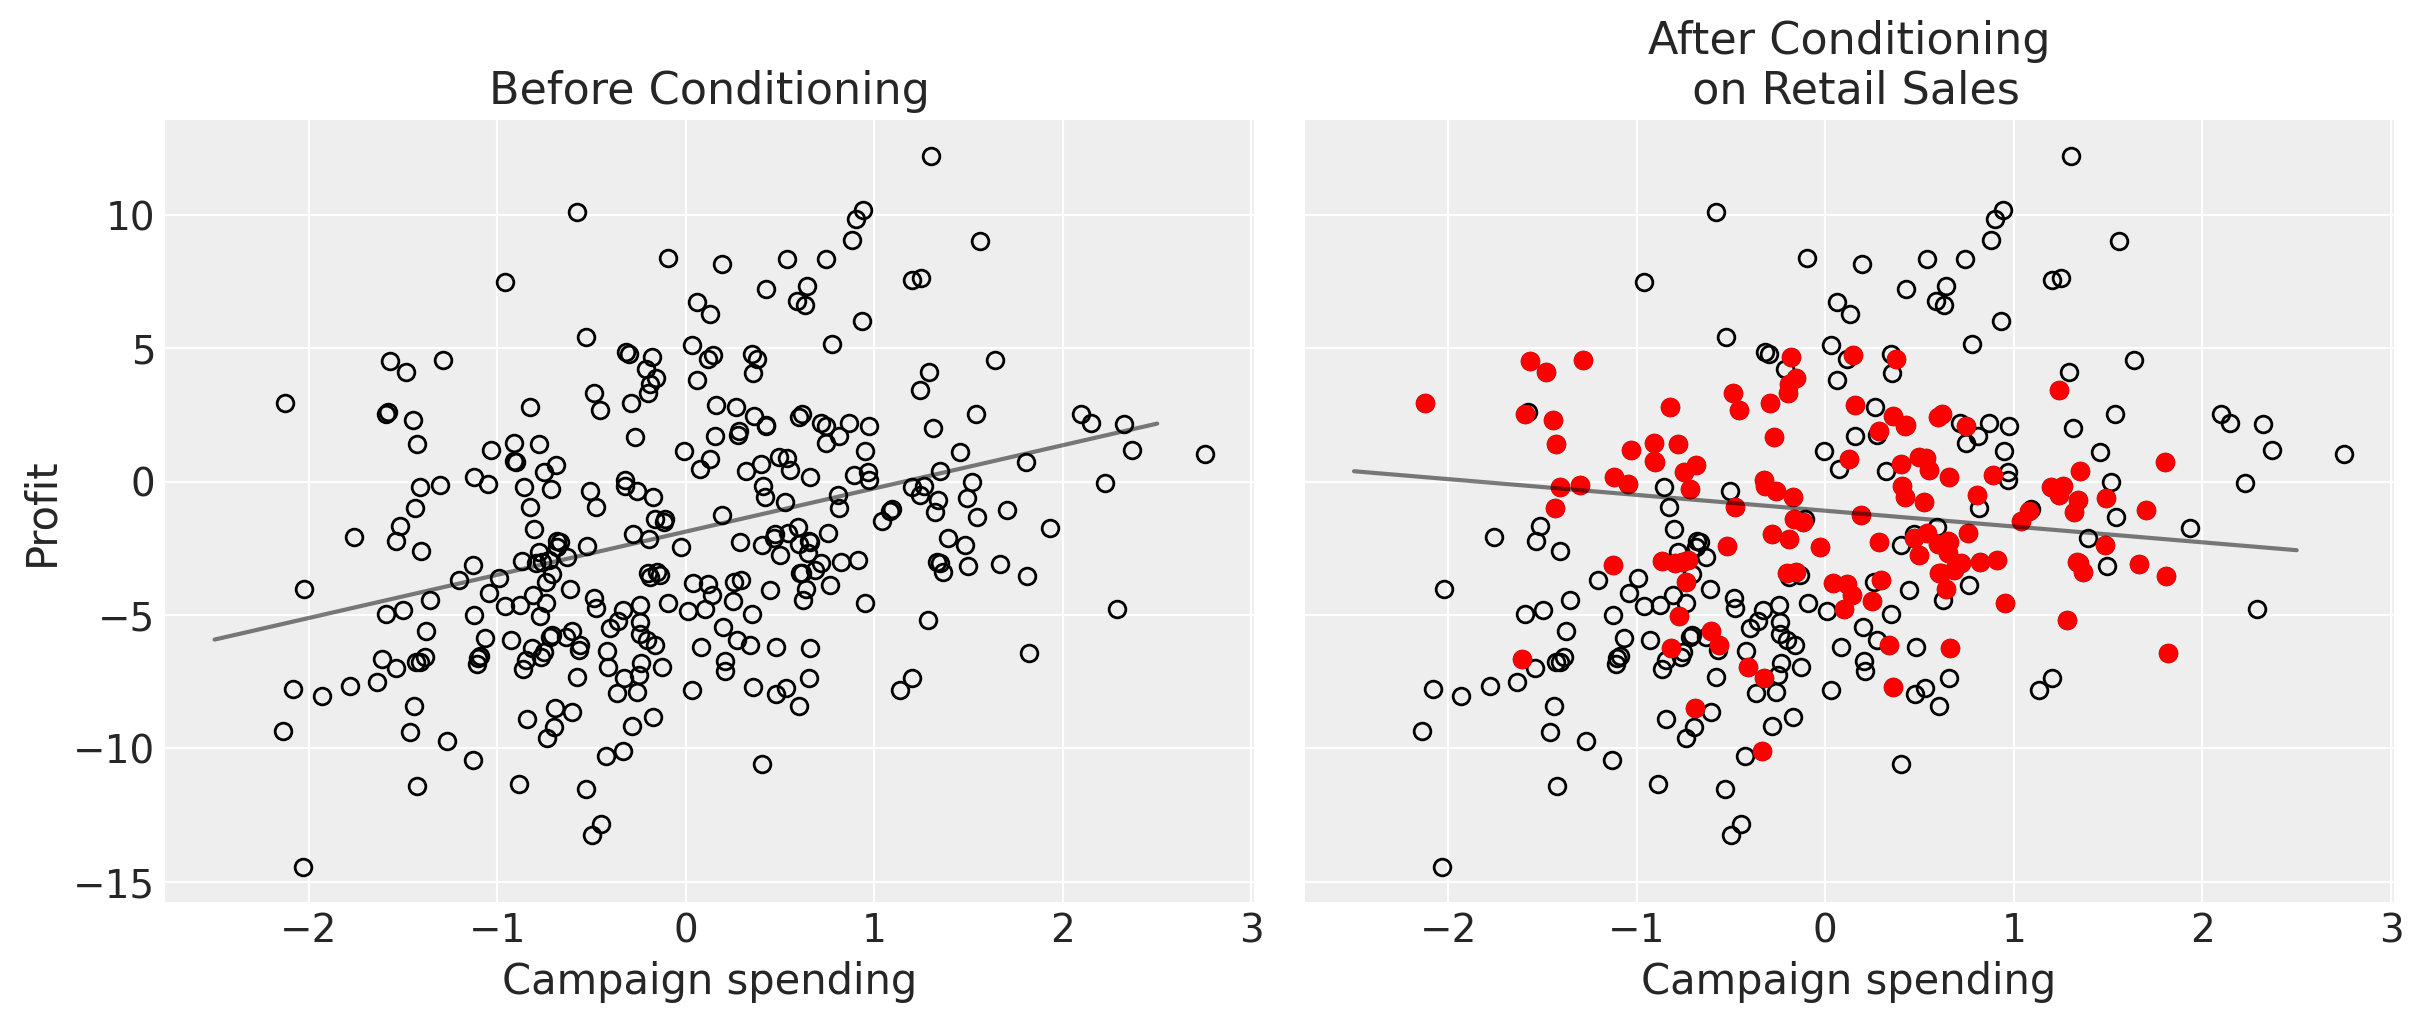

In [94]:
fig,axs=plt.subplots(1,2,figsize=(12,5),sharey=True)
conditions=[False,True]
#stratified_layer
retail_layer=(df['R']>-1) & (df['R']<1)
#line function
def linear(x,a,b):
  return a + b*x

for ax,condition in zip(axs.flat,conditions):
  ax.scatter(df.loc[:,'C'],df.loc[:,'P'],color=(0,0,0,0),edgecolors='k')
  ax.set(xlabel='Campaign spending')
  if condition:
    x=df.loc[:,'C'][retail_layer]
    y=df.loc[retail_layer,'P']
    ax.scatter(x,y,color='r')
    ax.set(title="After Conditioning\n on Retail Sales")
  else:
    x=df.loc[:,'C']
    y=df.loc[:,'P']
    ax.set(ylabel='Profit',title="Before Conditioning")
  ##line
  x_scale=np.linspace(-2.5,2.5,5)
  constant=curve_fit(linear,x,y)
  a_fit=constant[0][0]
  b_fit=constant[0][1]
  fit=[linear(i,a_fit,b_fit) for i in x_scale]
  ax.plot(x_scale,fit,color='k',alpha=0.5)



Text(0, 0.5, 'Profit')

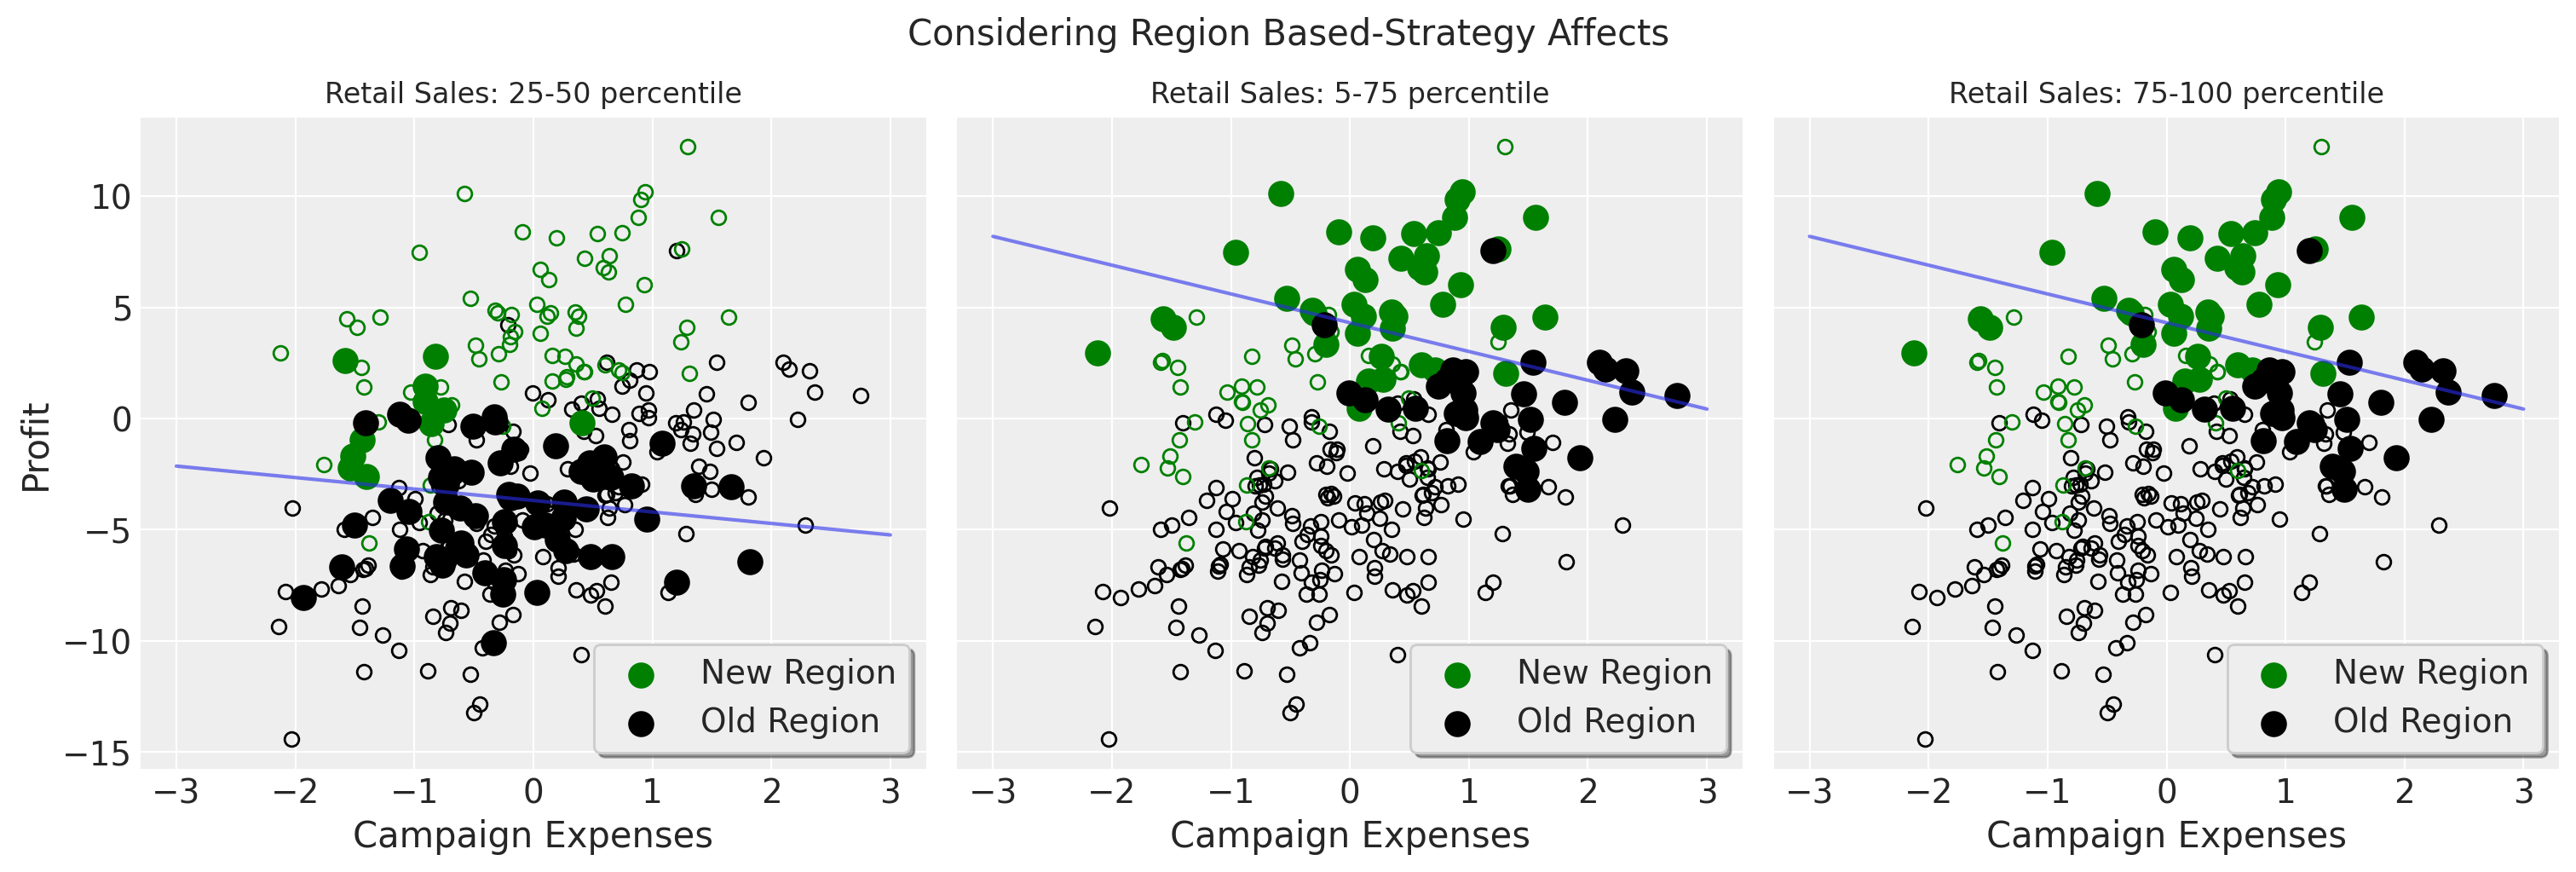

In [150]:
##for stratifications
def calc_quantile(series,per):
  ## returns calucated quantile value of Series at given percent
  return np.quantile(series,[per])[0]

## did not generated for quantiles below 15 percentile because There are not much same levels of profit for both new and old region as the mean for profit----
## shifts upward

retail_layer1=(df['R']>calc_quantile(df['R'],per=0.25)) & (df['R']<calc_quantile(df['R'],0.50))
retail_layer2=(df['R']>calc_quantile(df['R'],per=0.50)) & (df['R']<calc_quantile(df['R'],0.75))
retail_layer2=(df['R']>calc_quantile(df['R'],per=0.75)) & (df['R']<calc_quantile(df['R'],1))
layers=[retail_layer1,retail_layer2,retail_layer2]
titles=['Retail Sales: 25-50 percentile','Retail Sales: 50-75 percentile','Retail Sales: 75-100 percentile']
## filtering strategy affect
new_region=(df['U']==-1)
old_region=(df['U']==1)

#line function
def linear(x,a,b):
  return a + b*x

## polt
fig,axs=plt.subplots(1,3,figsize=(15,5),sharey=True)
fig.suptitle('Considering Region Based-Strategy Affects',fontsize=15)
for ax,layer,title in zip(axs.flat,layers,titles):
  ax.scatter(df.loc[new_region,'C'],df.loc[new_region,'P'],color=(0,0,0,0),edgecolors='k') ##color black for new regions
  ax.scatter(df.loc[old_region,'C'],df.loc[old_region,'P'],color=(0,0,0,0),edgecolors='g',) ##color green for old regions
  ax.scatter(df.loc[layer & old_region ,'C'],df.loc[layer & old_region,'P'],color='g',label='New Region',s = 100) 
  ax.scatter(df.loc[layer & new_region,'C'],df.loc[layer & new_region,'P'],color='k',label='Old Region',s = 100)
  ax.set(xlabel='Campaign Expenses')
  ax.set_title(title,fontsize=12)
  ## lines
  x_scale=np.linspace(-3,3,5)
  constant=curve_fit(linear,df.loc[layer,'C'],df.loc[layer,'P'])
  a_fit=constant[0][0]
  b_fit=constant[0][1]
  fit=[linear(i,a_fit,b_fit) for i in x_scale]
  ax.plot(x_scale,fit,alpha=0.6)
  ax.legend(frameon=True,shadow=True)
axs[0].set_ylabel('Profit')